# Приоритизация гипотез для увеличения выручки интернет-магазина. А/В тест

Есть список гипотез для увеличения выручки интернет-магазина.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**План**:

* Фреймворк ICE.
* Фреймворк RICE.
* Отличия в приоритизации гипотез при применении RICE и ICE.
* Кумулятивная выручка по группам.
* Кумулятивный средний чек по группам.
* График относительного изменения кумулятивного среднего чека группы B к группе A.
* График кумулятивной конверсии по группам.
* График относительного изменения кумулятивной конверсии группы B к группе A.
* Точечный график количества заказов по пользователям.
* 95-й и 99-й перцентили количества заказов на пользователя. 
* Точечный график стоимостей заказов.
* 95-й и 99-й перцентили стоимости заказов.
* Статистическая значимость различий в конверсии между группами по «сырым» данным.
* Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.
* Статистическая значимость различий в конверсии между группами по «очищенным» данным.
* Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
* Вывод

**Описание данных:**

Файл /datasets/hypothesis.csv. 
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv. 
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
# читаем датасеты
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# изучаем датасеты
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Оформление и изменение типов данных

In [6]:
# приводим название столбцов к единому стилю
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'})
# изменяем тип данных с object на datetime
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

### Пропуски и дубликаты

Пропуски я смотрю глазками обычно, когда вызываю info(). Перейду сразу к дубликатам.

In [7]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
print(orders['transaction_id'].duplicated().sum())
print(orders['visitor_id'].duplicated().sum())
visitors['date'].duplicated().sum()

0
166


31

В orders я проверил на дубликаты id транзакций, там нет дубликатов. Есть дубликаты в дате и id посетителей, но это не страшно, некоторые клиенты могли покупать за один день несколько раз. Есть также дубликаты в дате датафрейма visitors - 31 дубликат. Это объясняется тем, что для каждой группы (А,В) дата дублируется. Это нормально. Числовые признаки на дубликаты считаю проверять нет смысла.

### Количество групп в тесте

In [9]:
print(orders['group'].value_counts())
visitors['group'].value_counts()

B    640
A    557
Name: group, dtype: int64


A    31
B    31
Name: group, dtype: int64

Всего две группы участвуют в тесте.

### Распределение количества пользователей и период данных

In [10]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


In [11]:
min_date = visitors['date'].min()
max_date = visitors['date'].max()
print(min_date)
print(max_date)

2019-08-01 00:00:00
2019-08-31 00:00:00


In [12]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


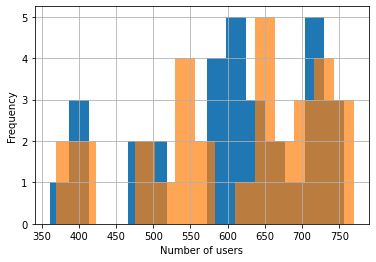

In [13]:
visitors.query('group == "A"')['visitors'].hist(bins=15);
visitors.query('group == "B"')['visitors'].hist(bins=15, alpha=0.7)
plt.xlabel("Number of users")
plt.ylabel("Frequency");

### Проверка на попадание в разные группы одинх и тех же пользователей

In [14]:
dubl = orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id'])
dubl.head()

2      True
7     False
8     False
10    False
12    False
Name: visitor_id, dtype: bool

89 пользователей в двух группах одновременно. Я удалю их из обеих.

In [15]:
abnormal_id = orders[orders['group']=='A'][dubl]['visitor_id']
abnormal_id

2       4069496402
26       199603092
29      3803269165
33      2378935119
41       237748145
           ...    
1167    4186807279
1173    2712142231
1178    2949041841
1183     963407295
1195    1614305549
Name: visitor_id, Length: 89, dtype: int64

In [16]:
orders = orders[~orders['visitor_id'].isin(abnormal_id)]
orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id']).value_counts()

False    468
Name: visitor_id, dtype: int64

## Фреймворк ICE

In [17]:
pd.options.display.max_colwidth = 210
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) / 
                     hypothesis['efforts']
                    ).round(2)
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


## Фреймворк RICE

In [18]:
hypothesis['rice'] = ((hypothesis['reach'] * hypothesis['impact'] * 
                       hypothesis['confidence']) / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by=['rice', 'ice'], ascending=False)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0


ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») - фреймворк для расчета ранга пририотизации гипотезы. Умножаем *Impact*(насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта) на *Сonfidence* (уверенность, что это изменение повлияет на пользователей именно так) и делим на *Efforts* (сколько стоит протестировать эту гипотезу).

У RICE в числителе добавляется множитель *Reach* (скольких пользователей затронет изменение).

Разница между приоритизацией методами ICE и RICE обусловлена тем, что в ICE не учитывается параметр reach - охват пользователей. 

Например, гипотеза о запуске акций (8) наиболее эффективна, но затронет лишь малую часть пользователей. В то время, как гипотеза 7 о добавлении формы на все страницы охватит большое количество пользователей при хорошем импакте и малых затратах. Разница RICE по этим двум гипотезам почти сто баллов.

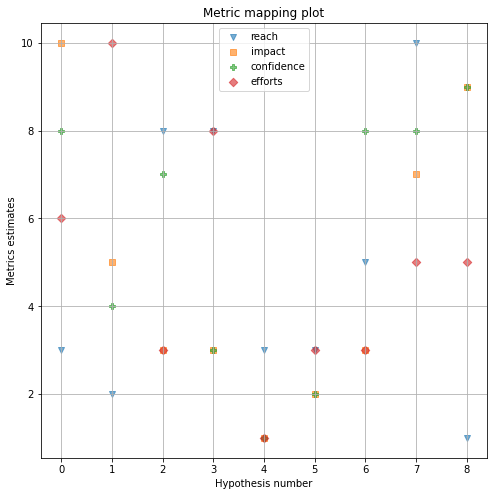

In [19]:
plt.rcParams["figure.figsize"] = (8,8)
markers = ['o', 'v', 's', 'P', 'D']
for j,i in enumerate(hypothesis.columns):
    if i not in ['hypothesis', 'rice', 'ice']:
        plt.scatter(x=hypothesis.index, y=hypothesis[i], label=i, alpha=0.6, marker=markers[j]) 
plt.grid()
plt.title('Metric mapping plot')
plt.xlabel("Hypothesis number")
plt.ylabel("Metrics estimates")
plt.legend();

## Кумулятивная выручка по группам

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
383,2019-08-03,B,54,53,288850
499,2019-08-04,A,77,71,388030
498,2019-08-04,B,68,66,385740
719,2019-08-05,A,99,92,474413
699,2019-08-05,B,89,87,475648


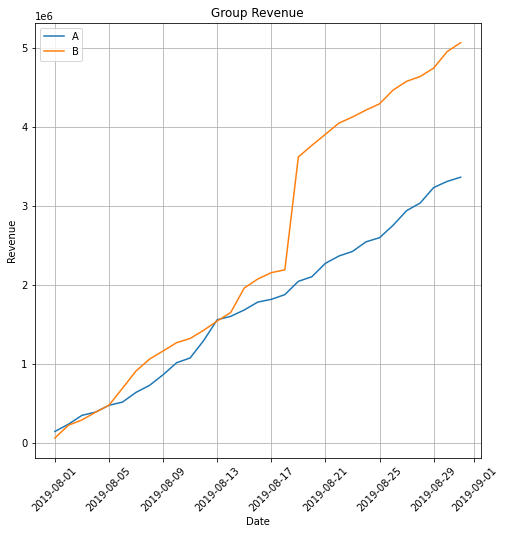

In [20]:
# создаем переменную с уникальными датами и группами
dates_groups = orders[['date', 'group']].drop_duplicates()
# агрегируем выручку
orders_agg = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
# агрегируем число пользоватлей
visitors_agg = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
# соединяем датафрейм выручки с количеством пользователей. 
# Получаем полный датафрейм с кумулятивной выручкой и числом пользователей по датам.
cumulative_df = orders_agg.merge(
    visitors_agg, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_df.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# делим кумулятивный датафрейм по выручке и сегментам А и В
cumulative_rev_a = cumulative_df.query('group == "A"')[['date', 'revenue', 'orders']]
cumulative_rev_b = cumulative_df.query('group == "B"')[['date', 'revenue', 'orders']]
# строим график кумулятивной выручки по сегментам
plt.plot(cumulative_rev_a['date'], cumulative_rev_a['revenue'], label='A')
plt.plot(cumulative_rev_b['date'], cumulative_rev_b['revenue'], label='B')
plt.grid()
plt.xticks(rotation=45)
plt.title('Group Revenue')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
orders_agg.head(10)

Выручка группы В, начиная с 5-ого августа превышает выручку группы А, 13 августа выручка по обеим группам равна. Примерно 18 августа наблюдается скачок в группе В, далее график растет линейно. В группе А никаких скачков не наблюдается. 

Возможно, скачок в группе В связан с аномально крупными заказами. Необходимо это проверить.

## Кумулятивный средний чек по группам

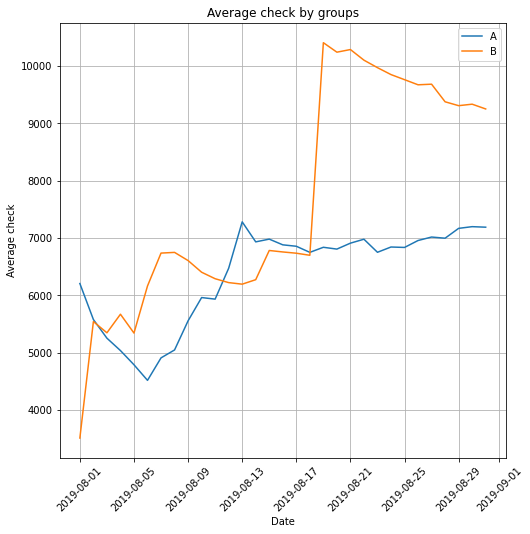

In [21]:
# строим график кумулятивного среднего чека по сегментам
plt.plot(cumulative_rev_a['date'], 
         cumulative_rev_a['revenue']/cumulative_rev_a['orders'], label='A')
plt.plot(cumulative_rev_b['date'], 
         cumulative_rev_b['revenue']/cumulative_rev_b['orders'], label='B')
plt.grid()
plt.xticks(rotation=45)
plt.title('Average check by groups')
plt.xlabel("Date")
plt.ylabel("Average check")
plt.legend();

Средние чеки по обеим группам сильно колеблются до 14 августа. Как и в графике с выручкой мы видим скачок 18 августа у группы В, но в отличие от того графика, здесь после скачка идет снижение - почти до 9000, у группы А почти 7500. Таким образом мы нивелировали влияние крупных заказов на последующие дни.

Снижение после скачка еще больше указывает на возможную аномалию в данных группы В. Также группе В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

## Относительное изменение кумулятивного среднего чека группы B к группе A

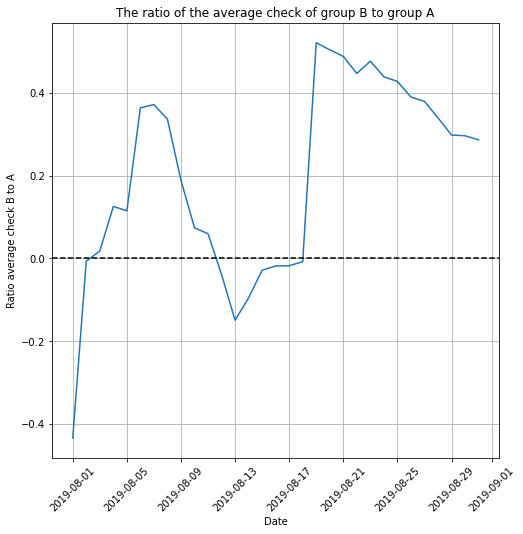

In [22]:
# соединяем выручку кумулятивную по А и В в один датафрейм
cumulative_rev = cumulative_rev_a.merge(cumulative_rev_b, 
                                        left_on='date', right_on='date',
                                        how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
plt.plot(cumulative_rev['date'], (cumulative_rev['revenue_b']/cumulative_rev['orders_b'])/
         (cumulative_rev['revenue_a']/cumulative_rev['orders_a'])-1)
plt.grid()
plt.xticks(rotation=45)
plt.title('The ratio of the average check of group B to group A')
plt.xlabel("Date")
plt.ylabel("Ratio average check B to A")
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

Видим три всплеска, где средний чек группы В больше чека группы А:

1. 1-3 августа
2. 5-7 августа
3. 18-19 августа

Наиболее резкий и подозрительный третий. Эти даты надо исследовать на аномалии.

## Конверсия по группам

In [23]:
cumulative_df

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


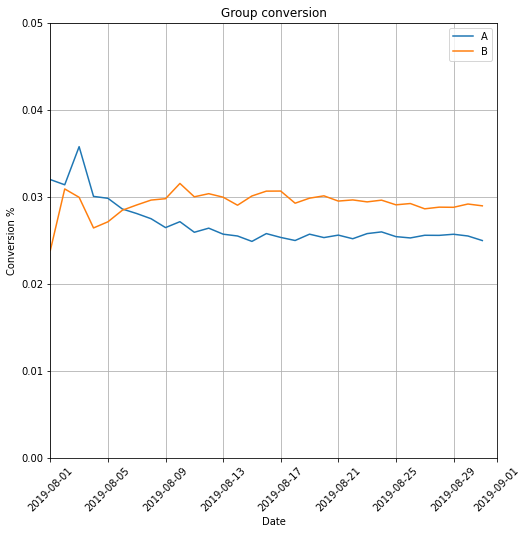

In [23]:
# считаем кумулятивную конверсию
cumulative_df['conversion'] = cumulative_df['orders']/cumulative_df['visitors']

# отделяем данные по группе A
cumulative_df_a = cumulative_df[cumulative_df['group']=='A']

# отделяем данные по группе B
cumulative_df_b = cumulative_df[cumulative_df['group']=='B']

# строим графики
plt.plot(cumulative_df_a['date'], cumulative_df_a['conversion'], label='A')
plt.plot(cumulative_df_b['date'], cumulative_df_b['conversion'], label='B')
plt.grid()
plt.xticks(rotation=45)
plt.title('Group conversion')
plt.xlabel("Date")
plt.ylabel("Conversion %")
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

Примерно с 6 августа группа В по конверсии обходит группу А, далее есть колебания, которые к 1 сентябрю практически угасают. 

Конверсия групп меняется в диапазоне от 2 до 3 процентов. Группа И фиксируется на 2.9%, группа А на 2.6% 

## Относительное изменение конверсии группы B к группе A

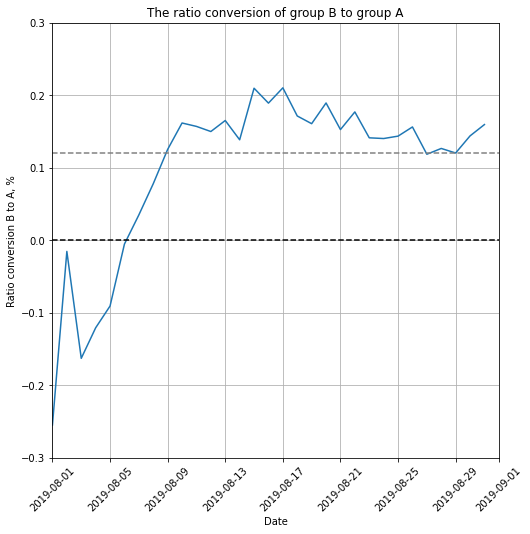

In [24]:
# общий датафрейм по конверсии по группам А и В
cumulative_conv = cumulative_df_a[['date','conversion']].merge(cumulative_df_b[['date','conversion']], 
                                                               left_on='date', right_on='date', 
                                                               how='left', suffixes=['_a', '_b'])

plt.plot(cumulative_conv['date'], cumulative_conv['conversion_b']/cumulative_conv['conversion_a']-1)
plt.grid()
plt.xticks(rotation=45)
plt.title('The ratio conversion of group B to group A')
plt.xlabel("Date")
plt.ylabel("Ratio conversion B to A, %")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.3, 0.3]); 

Практически с первых дней группа В лидировала. К 1 сентября она стала больше группы А примерно на 12%. Я бы не сказал, что значение зафиксировалось окончательно, возможно, тесту надо больше времени.

## Точечный график количества заказов по пользователям

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


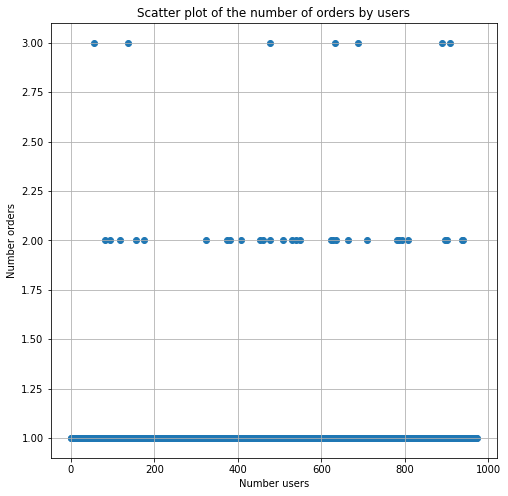

In [25]:
# количетсво уникальных заказов по пользователям
users_orders = (orders.groupby('visitor_id', as_index=False)
                .agg({'transaction_id' : 'nunique'})
               )
users_orders.columns = ['visitor_id', 'orders']
display(users_orders.sort_values(by='orders', ascending=False).head(10))
# точечный график количества заказов по пользователям
x_values = pd.Series(range(0, len(users_orders)))
plt.scatter(x=x_values, y=users_orders['orders'])
plt.grid()
plt.title('Scatter plot of the number of orders by users')
plt.xlabel("Number users")
plt.ylabel("Number orders");

3 заказа для одного пользователя уже редкость. Возможно стоит их принять за аномальные. Надо посмотреть по перцентилям.

## 95-й и 99-й перцентили количества заказов на пользователя.

In [26]:
print(np.percentile(users_orders['orders'], [95,99]))
perc_orders = list(np.percentile(users_orders['orders'], [95,99]))

[1. 2.]


Не более 5% пользователей совершили более одного заказа. Я приму 2 и более заказов за аномалию и исключу из дальнейшего исследования.

## Точечный график стоимостей заказов

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


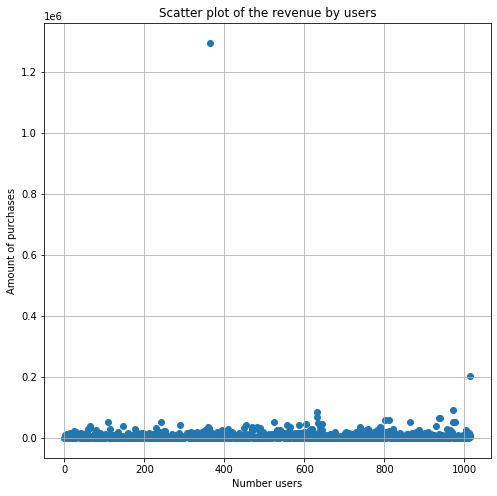

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.grid()
plt.title('Scatter plot of the revenue by users')
plt.xlabel("Number users")
plt.ylabel("Amount of purchases");
orders.sort_values(by='revenue', ascending=False).head(10)

Ярко выражены два выброса: 1.3 миллиона и 200 тысяч. Посмотрим перцентили.

## 95-й и 99-й перцентили стоимости заказов

In [28]:
print(np.percentile(orders['revenue'], [95,99]))
perc_rev = list(np.percentile(orders['revenue'], [95,99]))

[26785. 53904.]


Не более 5% пользователей делали заказы на сумму свыше 28 000. Я приму 26786 и более за аномалию и исключу из дальнейшего исследования.

## Статистическая значимость различий в конверсии по «сырым» данным

In [29]:
# фильтруем в отдельной переменной дату и число пользователей группы А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_a']
# кумулятивная сумма пользователей по дате
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']
# то же для сегмента В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']


In [30]:
# то же что и с чилом пользователей только по выручке
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_a', 'revenue_per_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_a': 'sum', 'revenue_per_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_b', 'revenue_per_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_b': 'sum', 'revenue_per_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


In [31]:
# соединяем предыдущие кумулятивные датафреймы в один
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_per_a,revenue_per_a,orders_per_b,revenue_per_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_a,visitors_per_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [32]:
# количество уникальных заказов у пользователей по группам.
users_orders_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
users_orders_a.columns = ['visitor_id', 'orders']

users_orders_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
users_orders_b.columns = ['visitor_id', 'orders']

In [33]:
# Последовательно объединяем по заказам пользователей сегментов А и В
# Присвоили нули тем, у кого нет заказов
sample_a = pd.concat(
    [
        users_orders_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_a'].sum() - len(users_orders_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        users_orders_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_b'].sum() - len(users_orders_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# Вычисляем p-value по Манну-Уитни и прирост средней конверсии сегмента В
print(st.mannwhitneyu(sample_a, sample_b)[1])
print("Относительный прирост средней конверсии группы B: {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.011018084110014696
Относительный прирост средней конверсии группы B: 0.160


**Нулевая гипотеза:** пропорции конверсии из посетителей в покупатели в группах А, В равны.

**Альтернативная гипотеза:** пропорции конверсии из посетителей в покупатели в группах А, В различны.

Уровень значимости: alpha = 0.05. Я выбираю такое значение alpha, так как считаю, что в данном исследование последствия ошибки первого рода не критичны.

P-value не превышает уровень значимости в 5% (1.1%). Значит между средними конверсиями групп А и В по сырым данным есть статистически значимые отличия. Исходя из этих данных отвергаем нулевую гипотезу. 

Относительное различие средних конверсий между группами А и В 16%. Выводы надо сделать после анализа очищенных данных.

## Статистическая значимость различий в среднем чеке между группами по «сырым» данным

In [34]:
# То же только со средним чеком
print(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
      orders[orders['group']=='B']['revenue'])[1])
print('Относительный прирост среднего чека группы B: {0:.3f}'
      .format(orders[orders['group']=='B']['revenue']
      .mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.8294908998149533
Относительный прирост среднего чека группы B: 0.287


**Нулевая гипотеза:** средний чек у покупателей в группах А, В одинаковый.

**Альтернативная гипотеза:** средний чек у покупателей в группах А, В различный.

P-value превышает уровень значимости в 5% (83%). Значит между средними чеками групп А и В по сырым данным статистически значимых отличий нет. 

Однако относительное различие среднего чека между группами А и В целых 28.7%. Это много. Выводы надо сделать после анализа очищенных данных

## Статистическая значимость различий в конверсии между группами по «очищенным» данным

Я возьму верхний предел по количеству заказов - 1, по сумме заказа - 27 000. Данные больше этих значений я отсеку.

In [35]:
order_max = perc_orders[0]
rev_max = perc_rev[0]
# переменная с аномальным количеством заказов
many_orders = pd.concat(
    [
        users_orders_a[users_orders_a['orders'] > order_max]['visitor_id'],
        users_orders_b[users_orders_b['orders'] > order_max]['visitor_id'],
    ],
    axis=0,
)
# переменная с аномальной суммой заказа
expensive_orders = orders[orders['revenue'] > rev_max]['visitor_id']
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.head(5)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

In [36]:
# Последовательно объединяем по заказам пользователей сегментов А и В по очищенным данным
# Присвоили нули тем, у кого нет заказов
sample_a_filtered = pd.concat(
    [
        users_orders_a[
            np.logical_not(users_orders_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_a'].sum() - len(users_orders_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        users_orders_b[
            np.logical_not(users_orders_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_b'].sum() - len(users_orders_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [37]:
# Вычисляем p-value по Манну-Уитни и прирост средней конверсии сегмента В по очищенным данным
print(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1])
print('{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

0.01593020716573973
0.174


По очищенным данным также отвергаем нулевую гипотезу. Группа В лучше группы А по средней конверсии на 17.4%

## Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [38]:
# То же только со средним чеком
print(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )


print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.7271286894009963
-0.034


Не отвергаем нулевую гипотезу: 72% p-value. Отличие в -3.4% (против +25% при сырых данных) по среднему чеку между группами статистически не значимо.

## Вывод

In [39]:
orders.query('group == "B"').count()

transaction_id    548
visitor_id        548
date              548
revenue           548
group             548
dtype: int64

In [40]:
orders.query('group == "A"').count()

transaction_id    468
visitor_id        468
date              468
revenue           468
group             468
dtype: int64

In [41]:
visitors['visitors'].mean()

607.2903225806451

Исходя из проверок гипотез по очищенным данным получается:

1. Средняя конверсия пользователей группы В лучше группы А на 17.4%
2. Средний чек у группы А выше на 3.4% чем у группы В.

Несмотря на то, что конверсия у группы В высокая, качество пользователей не изменилось, они покупают примерно на ту же сумму (72% вероятность того, что средние чеки в группах одинаковые).

График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя.

Графики кумулятивного чека и относительного изменения конверсии группы B к группе A зафиксировались даже по сырым данным.

**ВЫВОД:**

Несмотря на то, что улучшений по среднему чеку нет, есть улучшения по конверсии из пользователей в покупатели - 17.4% - и это не случайное значение. Я признаю тест успешным и завершу его. В любом случае продолжать тест и "подглядывать" нет смысла, лучше уж потом запустить его заново, если что.